In [1]:
import sys
sys.version 

'3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]'

In [2]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [22]:
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
# logging.langsmith("code_review_agent")

# logging.langsmith("code_review_agent", set_enable=False)

In [3]:
import os
import re
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser
from langchain.tools import Tool

gpt4_0 = ChatOpenAI(model= "gpt-4o", temperature=0)
gpt3_0 = ChatOpenAI(model= "gpt-3.5-turbo", temperature=0)

# 함수 정의

In [19]:
from typing import Type, Callable, Dict, Any
from pydantic import BaseModel, Field
from langchain.tools import Tool

# 텍스트에서 파이썬 코드 블록을 추출하는 함수
def _sanitize_output(text: str):
    _, after = text.split("```python")
    return after.split("```")[0].strip()

# print 삽입 함수
# class CustomStrOutputParser(StrOutputParser):
#     def parse(self, output: str):
#         print(output)
#         return super().parse(output)

# 모델과 구조화된 출력 체인을 생성하는 함수
def create_structured_output_chain(
    system_template: str, 
    human_template: str,
    model: str,
    struct: Type[BaseModel],
    partial_variables: Dict[str, Any] = {}
) -> Callable:

    # 시스템 및 사용자 입력을 위한 프롬프트 템플릿 생성
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_template), 
        ("human", human_template)
    ]).partial(**partial_variables)

    # 모델 선택 딕셔너리
    model_mapping = {
        "gpt4_0": ChatOpenAI(model="gpt-4o", temperature=0),
        "gpt3_0": ChatOpenAI(model="gpt-3.5-turbo", temperature=0),
        "gpt4": ChatOpenAI(model="gpt-4o"),
        "default": ChatOpenAI(model="gpt-3.5-turbo")
    }

    # 선택된 모델을 사용하여 체인 반환
    model_instance = model_mapping.get(model, model_mapping["default"])
        
    # 모델과 구조화된 출력 연결
    return prompt | model_instance.with_structured_output(struct)

In [5]:
import operator
from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated, Optional, List

# 코드 분석 상태를 나타내는 데이터 구조
class CodeAnalysisState(TypedDict):
    user_input: str
    output: str
    problem_description: str
    user_code: str
    input_data: str
    time_complexity: str
    space_complexity: str
    exec_code: str
    memory_code: str
    profiling_result: str
    memory_profile_output: str
    error_status: str
    exec_time: float
    memory_usage: dict
    code_complexity: dict

# 코드 분석 출력을 위한 데이터 정의
class CodeAnalysisOutput(BaseModel):
    problem_description: str = Field(description="The extracted problem description")
    user_code: str = Field(description="The extracted user's Python code")
    input_data: Optional[str] = Field(description="The extracted input data for testing the code")
    time_complexity: str = Field(description="Time complexity analysis of the user's code")
    space_complexity: str = Field(description="Space complexity analysis of the user's code")

# 사용자 입력을 파싱하는 함수
def parse_user_input(state: CodeAnalysisState):
    system_template = """
    Analyze the following user input and extract the following components:
    1. The coding test problem description
    2. The user's Python code
    3. The input data for testing the code (if provided)
    
    Then, based on the extracted user's Python code:
    4. Analyze and estimate the time complexity of the code
    5. Analyze and estimate the space complexity of the code
    
    Provide detailed explanations for your complexity analyses, considering the algorithmic approach used in the code.
    
    Provide your analysis in a structured format.
    """

    chain = create_structured_output_chain(
        system_template=system_template,
        human_template="{user_input}",
        model="gpt3_0",
        struct=CodeAnalysisOutput,
        partial_variables={"user_input": state["user_input"]}
    )
    
    return chain.invoke(state)

In [6]:
from typing import Dict
import ast

# 코드 복잡도 분석 함수
def analyze_code_complexity(state: CodeAnalysisState) -> CodeAnalysisState:
    code = state['user_code']
    
    # AST로 코드 파싱 후 복잡도 분석 (함수, 클래스, 루프, 조건문의 개수)
    tree = ast.parse(code)
    code_complexity = {
        'num_functions': len([node for node in ast.walk(tree) if isinstance(node, ast.FunctionDef)]),
        'num_classes': len([node for node in ast.walk(tree) if isinstance(node, ast.ClassDef)]),
        'num_loops': len([node for node in ast.walk(tree) if isinstance(node, (ast.For, ast.While))]),
        'num_conditionals': len([node for node in ast.walk(tree) if isinstance(node, ast.If)])
    }
    
    # 상태에 코드 복잡도 추가
    state['code_complexity'] = code_complexity
    return state

In [7]:
class ExecCodeOutput(BaseModel):
    exec_code: str = Field(description="The modified Python code that can be executed directly using Python's exec() function. This code includes hardcoded input data and any necessary function calls to ensure it runs without modification.")

# 코드 실행을 위한 Python 코드 수정 함수
def modify_user_code_for_execution(state: CodeAnalysisState): 
    # 입력 데이터 하드코딩 및 함수 호출 추가 템플릿
    system_template = """
    You are provided with a Python code and input data. Your task is to prepare the code so that it can be executed directly using the exec function in Python.
    
    Your task is to:
    1. Ensure that the input data is correctly hardcoded into the user's code in the appropriate places.
    2. If the code contains any functions (e.g., a main function or any other defined functions), add the necessary function calls at the bottom if they are missing.
    3. Do not change the structure or logic of the user's code.
    4. Ensure that after modification, the code is ready to be executed directly with the exec function.
    
    Please return the modified Python code that can be executed directly using exec.
    """

    human_template ="""
    User Code:
    ```python
    {user_code}
    ```
    
    Input Data: {input_data}
    """
    
    chain = create_structured_output_chain(
        system_template=system_template,
        human_template=human_template,
        model="gpt4_0",
        struct=ExecCodeOutput,
        partial_variables={"user_code": state["user_code"], "input_data": state["input_data"]}
    )
    
    return chain.invoke(state)

In [8]:
class MemoryCodeOutput(BaseModel):
    memory_code: str = Field(description="The modified Python code that includes memory profiling using the memory_profiler library. The code contains necessary imports and the @profile decorator added to relevant functions for memory usage tracking. If required, appropriate function calls are added to ensure execution.")

# 메모리 프로파일링을 위한 코드 수정 함수
def modify_code_with_memory_profiler(state: CodeAnalysisState):
    # memory_profiler 데코레이터 추가 템플릿
    system_template = """
    You are provided with a Python code. Your task is to modify the code so that the memory usage of the code can be profiled using the memory_profiler library.
    
    Your task is to:
    1. Add the necessary imports for memory profiling (from memory_profiler import profile).
    2. Add the @profile decorator above the main function or relevant functions that should be profiled for memory usage.
    3. Ensure that the original structure and logic of the user's code remain unchanged.
    4. If there is no function execution (such as 'main()' or any other function calls), add the appropriate function call at the end of the code so that the function decorated with @profile is executed. This is important because the @profile decorator must be triggered for memory usage to be tracked.
    
    Additionally, keep in mind that the modified code will be executed using a subprocess. Ensure that the code can be executed in this environment without errors.
    
    Please return the modified Python code with @profile decorator added, memory_profiler set up, and any missing function calls appropriately added. 
    """
    
    human_template ="""
    User Code:
    ```python
    {user_code}
    ```
    """
    
    chain = create_structured_output_chain(
        system_template=system_template,
        human_template=human_template,
        model="gpt4_0",
        struct=MemoryCodeOutput,
        partial_variables={"user_code": state["exec_code"]}
    )
    
    return chain.invoke(state)

In [9]:
import cProfile
import pstats
import io
import timeit
import tracemalloc
import tempfile
import subprocess
import os

# 코드 실행 및 메모리/성능 분석 함수
def analyze_code(state: CodeAnalysisState) -> CodeAnalysisState:
    exec_code = state['exec_code']
    memory_code = state['memory_code']
    
    exec_time = 0
    memory_usage = {'current_memory': 0, 'peak_memory': 0}
    profiling_result = ""
    memory_profile_output = ""  # 라인별 메모리 사용량 측정 (외부 프로세스에서)
    error_status = "no_error"
        
    # cProfile을 사용한 성능 프로파일링
    profiler = cProfile.Profile()
    
    try:
        tracemalloc.start()  # 메모리 사용량 측정 시작
        start_time = timeit.default_timer()  # 시간 측정 시작
        profiler.enable()  # 성능 프로파일링 시작
        
        exec(exec_code, globals())  # exec로 코드 실행
        
        # 프로파일링 도구 종료
        profiler.disable()  # 성능 프로파일링 종료
        end_time = timeit.default_timer()  # 시간 측정 종료
        current, peak = tracemalloc.get_traced_memory()  # 메모리 사용량 측정 종료
        tracemalloc.stop()  # 메모리 추적 종료

        # 실행 시간 및 메모리 사용량 저장
        exec_time = end_time - start_time
        memory_usage = {
            'current_memory': current / 10**6,  # MB 단위
            'peak_memory': peak / 10**6         # MB 단위
        }
        
        # profiler.print_stats() 결과를 변수에 담기
        s = io.StringIO()
        ps = pstats.Stats(profiler, stream=s)
        ps.print_stats()
        profiling_result = s.getvalue()

    except Exception:
        error_status = "exec_error"
    
    # memory_code를 위한 임시 파일 생성 (subprocess에서 메모리 프로파일링할 코드)
    with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False, encoding='utf-8') as temp_file_memory:
        temp_file_name_memory = temp_file_memory.name
        temp_file_memory.write(memory_code)

    # memory_profiler를 사용하여 라인별 메모리 사용량 측정
    try:
        command = f"python -m memory_profiler {temp_file_name_memory}"
        result = subprocess.run(command, shell=True, capture_output=True, text=True, check=True)
        
        # 라인별 메모리 사용량만 출력
        memory_profile_output = result.stdout

    except subprocess.CalledProcessError:
        memory_profile_output = "subprocess_error"
    
    finally:
        # 임시 파일 삭제
        os.remove(temp_file_name_memory)
        
    # 상태에 결과 저장
    state['exec_time'] = exec_time
    state['memory_usage'] = memory_usage
    state['profiling_result'] = profiling_result
    state['memory_profile_output'] = memory_profile_output
    state['error_status'] = error_status

    return state


In [10]:
from langchain.schema import StrOutputParser

# 코드 분석 결과를 생성하는 함수
def generate_code_analysis(state: CodeAnalysisState) -> CodeAnalysisState:
    system_template = """You are an expert code analyzer and performance optimization specialist. 
    Your task is to analyze the given code performance metrics and provide insights and optimization suggestions.
    
    Consider the following aspects in your analysis:
    1. Time complexity
    2. Space complexity
    3. Execution time
    4. Memory usage
    5. Profiling results (using cProfile)
    6. Memory profile output (using @profile decorator)
    7. Code complexity (number of functions, classes, loops, conditionals)
    
    Provide a comprehensive analysis and suggest optimizations if necessary.
    """
    
    human_template = """Please analyze the following code performance metrics:
    
    User Code:
    ```python
    {user_code}
    ```
      
    Time Complexity: {time_complexity}
    Space Complexity: {space_complexity}
    Execution Time: {exec_time} seconds
    Memory Usage: Current - {current_memory} MB, Peak - {peak_memory} MB
    
    Code Complexity:
    - Number of Functions: {num_functions}
    - Number of Classes: {num_classes}
    - Number of Loops: {num_loops}
    - Number of Conditionals: {num_conditionals}
    
    Profiling Result (using cProfile):
    {profiling_result}
    
    Memory Profile Output (using @profile decorator):
    {memory_profile_output}
    
    Based on these metrics, provide an analysis of the code's performance and suggest optimizations if necessary.
    """

    input_state_data = {
        "user_code": state['user_code'],
        "time_complexity": state['time_complexity'],
        "space_complexity": state['space_complexity'],
        "exec_time": state['exec_time'],
        "current_memory": state['memory_usage'].get("current_memory", "N/A"),  # 현재 메모리 사용량
        "peak_memory": state['memory_usage'].get("peak_memory", "N/A"),        # 최고 메모리 사용량
        "num_functions": state['code_complexity'].get("num_functions", 0),     # 함수 수
        "num_classes": state['code_complexity'].get("num_classes", 0),         # 클래스 수
        "num_loops": state['code_complexity'].get("num_loops", 0),             # 루프 수
        "num_conditionals": state['code_complexity'].get("num_conditionals", 0), # 조건문 수
        "profiling_result": state['profiling_result'],
        "memory_profile_output": state['memory_profile_output']
    }

    # 분석 수행
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_template), 
        ("human", human_template)
    ])

    chain = prompt | gpt4_0 | StrOutputParser()
    result = chain.invoke(input_state_data)
    
    # 분석 결과를 상태의 output에 저장
    state['output'] = result
    return state

## Coding Review Graph

In [11]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 코드 분석 워크플로우 생성
code_analysis_workflow = StateGraph(CodeAnalysisState)

In [12]:
from langgraph.graph import START, END, StateGraph

# 워크플로우에 각 기능을 노드로 추가
code_analysis_workflow.add_node("parse_user_input", parse_user_input)
code_analysis_workflow.add_node("analyze_code_complexity", analyze_code_complexity)
code_analysis_workflow.add_node("modify_user_code_for_execution", modify_user_code_for_execution)
code_analysis_workflow.add_node("modify_code_with_memory_profiler", modify_code_with_memory_profiler)
code_analysis_workflow.add_node("analyze_code", analyze_code)
code_analysis_workflow.add_node("generate_code_analysis", generate_code_analysis)

# 노드 간의 실행 순서를 설정
code_analysis_workflow.add_edge("parse_user_input", "analyze_code_complexity")
code_analysis_workflow.add_edge("analyze_code_complexity", "modify_user_code_for_execution")
code_analysis_workflow.add_edge("modify_user_code_for_execution", "modify_code_with_memory_profiler")
code_analysis_workflow.add_edge("modify_code_with_memory_profiler", "analyze_code")
code_analysis_workflow.add_edge("generate_code_analysis", END)

# 조건부 경로 설정 (에러 상태에 따라 경로가 달라짐)
code_analysis_workflow.add_conditional_edges(
    "analyze_code",
    lambda state: state["error_status"], # 상태에서 error_status 값을 추출
    {
        "no_error": "generate_code_analysis", # 오류가 없으면 generate_code_analysis로 이동
        "exec_error": "modify_user_code_for_execution", # 코드 실행 중 오류가 발생하면 modify_user_code_for_execution로 이동
        "subprocess_error": "modify_code_with_memory_profiler" # 서브프로세스 실행 중 오류가 발생하면 modify_code_with_memory_profiler로 이동
    }
)

# 워크플로우 시작점을 설정
code_analysis_workflow.set_entry_point("parse_user_input")

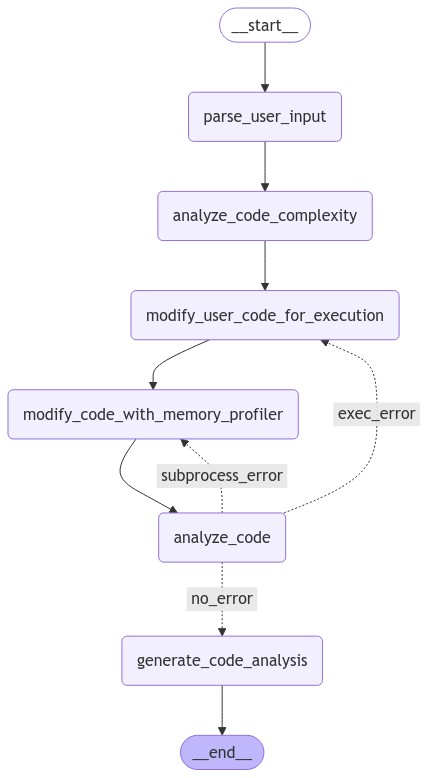

In [13]:
# 워크플로우를 컴파일하고 그래프 시각화
code_analysis_app = code_analysis_workflow.compile()

from IPython.display import Image, display
try:
    display(Image(code_analysis_app.get_graph().draw_mermaid_png()))
except Exception:
    pass

# 결과물

In [14]:
test_input = """
I need help with this coding problem: Leetcode Problem 200 - Number of Islands.
Given an m x n 2D binary grid grid which represents a map of '1's (land) and '0's (water), return the number of islands. An island is surrounded by water and is formed by connecting adjacent lands horizontally or vertically. You may assume all four edges of the grid are all surrounded by water.

Here's my code:
def numIslands(grid):
    if not grid:
        return 0
 
    rows, cols = len(grid), len(grid[0])
    num_islands = 0
 
    # DFS function to traverse the island
    def dfs(r, c):
        if r < 0 or c < 0 or r >= rows or c >= cols or grid[r][c] == '0':
            return
        grid[r][c] = '0'  # Mark the cell as visited
        # Visit all four directions
        dfs(r-1, c)
        dfs(r+1, c)
        dfs(r, c-1)
        dfs(r, c+1)
 
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == '1':
                dfs(r, c)
                num_islands += 1
 
    return num_islands

Can you review my code and test it with this input: 
grid = [
  ["1","1","0","0","0"],
  ["1","1","0","0","0"],
  ["0","0","1","0","0"],
  ["0","0","0","1","1"]
]
"""

In [15]:
from langchain_core.messages import HumanMessage
output = code_analysis_app.invoke(CodeAnalysisState(user_input=test_input))

3


In [16]:
output["output"]

"### Analysis of Code Performance\n\n#### 1. Time Complexity\nThe time complexity of the `numIslands` function is O(m*n), where `m` is the number of rows and `n` is the number of columns in the grid. This is because each cell is visited once, and the DFS function explores all four directions for each cell.\n\n#### 2. Space Complexity\nThe space complexity is also O(m*n) due to the recursion stack used by the DFS function. In the worst case, the recursion stack can grow to the size of the entire grid if the grid is filled with '1's.\n\n#### 3. Execution Time\nThe execution time is 0.004192200023680925 seconds, which is quite efficient for the given problem. This indicates that the function performs well within acceptable limits for typical input sizes.\n\n#### 4. Memory Usage\n- **Current Memory Usage:** 0.013563 MB\n- **Peak Memory Usage:** 0.099895 MB\n\nThe memory usage is minimal, indicating that the function is memory efficient.\n\n#### 5. Profiling Results (using cProfile)\nThe pr

In [17]:
from IPython.display import display, Markdown
display(Markdown(output["output"]))

### Analysis of Code Performance

#### 1. Time Complexity
The time complexity of the `numIslands` function is O(m*n), where `m` is the number of rows and `n` is the number of columns in the grid. This is because each cell is visited once, and the DFS function explores all four directions for each cell.

#### 2. Space Complexity
The space complexity is also O(m*n) due to the recursion stack used by the DFS function. In the worst case, the recursion stack can grow to the size of the entire grid if the grid is filled with '1's.

#### 3. Execution Time
The execution time is 0.004192200023680925 seconds, which is quite efficient for the given problem. This indicates that the function performs well within acceptable limits for typical input sizes.

#### 4. Memory Usage
- **Current Memory Usage:** 0.013563 MB
- **Peak Memory Usage:** 0.099895 MB

The memory usage is minimal, indicating that the function is memory efficient.

#### 5. Profiling Results (using cProfile)
The profiling results show that the function `numIslands` and its nested `dfs` function are called multiple times, but the total time spent in these functions is minimal. The majority of the time is spent in the `dfs` function, which is expected due to its recursive nature.

#### 6. Memory Profile Output (using @profile decorator)
The memory profile output shows that the memory usage remains constant throughout the execution of the function. There are no significant memory spikes, indicating efficient memory management.

#### 7. Code Complexity
- **Number of Functions:** 2 (`numIslands` and `dfs`)
- **Number of Classes:** 0
- **Number of Loops:** 2 (nested loops to iterate over the grid)
- **Number of Conditionals:** 3 (one in `numIslands` and two in `dfs`)

The code complexity is low, making it easy to understand and maintain.

### Optimization Suggestions

1. **Iterative DFS/BFS:**
   - The current implementation uses a recursive DFS, which can lead to a stack overflow for very large grids. An iterative approach using a stack or queue can mitigate this risk.
   - **Example:**
     ```python
     def numIslands(grid):
         if not grid:
             return 0

         rows, cols = len(grid), len(grid[0])
         num_islands = 0

         def bfs(r, c):
             queue = [(r, c)]
             while queue:
                 r, c = queue.pop(0)
                 if r < 0 or c < 0 or r >= rows or c >= cols or grid[r][c] == '0':
                     continue
                 grid[r][c] = '0'
                 queue.append((r-1, c))
                 queue.append((r+1, c))
                 queue.append((r, c-1))
                 queue.append((r, c+1))

         for r in range(rows):
             for c in range(cols):
                 if grid[r][c] == '1':
                     bfs(r, c)
                     num_islands += 1

         return num_islands
     ```

2. **In-place Modification:**
   - The current implementation modifies the input grid in place. If the input grid should not be modified, consider creating a copy of the grid before processing.

3. **Early Exit:**
   - If the grid is very large and the number of islands is known to be small, consider adding an early exit condition to stop processing once a certain number of islands are found.

4. **Parallel Processing:**
   - For very large grids, consider parallelizing the processing of different parts of the grid using multi-threading or multi-processing to speed up the execution time.

### Conclusion
The current implementation of the `numIslands` function is efficient in terms of both time and space complexity. The execution time and memory usage are within acceptable limits. However, for very large grids, an iterative approach to DFS/BFS can be more robust and prevent stack overflow issues. Additionally, parallel processing can be considered for further optimization.